# Reproducing Results from Primary Isolines Paper

### Code taken from Dan Cooley's Website

Implemented with both the RData from his website, as well as the data extracted from NetCDF files on Cori (for practice/completeness)

In [1]:
library(MASS)
library(ismev)
library(evd)
library(chron)

Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.



In [7]:
#############
# secondary functions
#############

#functions to transform marginals (nonparametric below threshold, gpd above, blended)
#note:  blending is not "consistent" for both trans and invTrans--should it be?
#no guarantee that blending will result in non-decreasing cdf
transMar <- function(x, dat, marginal = 1, marProp, marWidth, gpdOut)
{
	n <- length(dat[,marginal])
	u <- (rank(dat[,marginal])-1)/(n)
	empirical <- approx(x=dat[,marginal], y=u, xout = x)$y
	tooLow <- which(x <= min(dat[,marginal]))
	tooHigh <- which(x > max(dat[,marginal]))
	empirical[tooLow] <- 0
	empirical[tooHigh] <- 1	
	pgpdOut <- evd::pgpd(x, loc = gpdOut$threshold, scale = gpdOut$mle[1], shape = gpdOut$mle[2])
	gpdModel <- (1 - marProp) + marProp * pgpdOut
	width <- diff(quantile(dat[,marginal], probs = c(1 - marProp, 1 - marProp + marWidth)))
	weight <- numeric(length(x))
	below <- which(x < gpdOut$threshold)
	above <- which(x > gpdOut$threshold + width)
	between <- which(x >= gpdOut$threshold & x <= gpdOut$threshold+width)
	weight[below] <- 0
	weight[above] <- 1
	weight[between] <- (sin(pi/width*(x[between] - gpdOut$threshold) - pi/2) + 1)/2
	return(weight*gpdModel + (1 - weight)*empirical)	
}

In [8]:
invTransMar <- function(u, dat, marginal = 1, marProp, marWidth, gpdOut)
{
	if(any(u < 0) | any(u >= 1)){stop("u must be =< 0 and > 1")}
	n <- length(dat[,marginal])
	uDat <- (rank(dat[,marginal])-1)/(n)
	empirical <- approx(x = uDat, y=dat[,marginal], xout = u)$y
	tooLow <- which(u == 0)
	tooHigh <- which(u > max(uDat))
	empirical[tooLow] <- min(dat[,marginal])
	empirical[tooHigh] <- max(dat[,marginal])
	below <- which(u <= 1 - marProp)
	above <- which(u > 1 - marProp + marWidth)
	between <- which(u > 1 - marProp & u <= 1 - marProp + marWidth)
	qgpdOut <- numeric(length(u))
	qgpdOut[-below] <- evd::qgpd((u[-below]-(1 - marProp))/marProp, 
			loc = gpdOut$threshold, scale = gpdOut$mle[1], shape = gpdOut$mle[2])
	qgpdOut[below] <- 0
	weight <- numeric(length(u))
	weight[below] <- 0
	weight[above] <- 1
	weight[between] <- (u[between] - (1 - marProp))/marWidth
	weighted <- weight*qgpdOut + (1 - weight)*empirical
	return(weighted)
}

In [9]:
#kernel survival est function
kernSurv <- function(loc, dat, bw)
{
	p1 <- 1 - pnorm(loc[1], mean = dat[,1], sd = bw[1]/4)
	p2 <- 1 - pnorm(loc[2], mean = dat[,2], sd = bw[2]/4)
	return(mean(p1*p2))
}

In [10]:
#################
# primary function
#################

xContours <- function(dat, mar1Prop = .03, mar2Prop = .03, mar1Width = .01, mar2Width = .01, 
		baseContourLevel = .01, projContourLevels = c(.005, .001, .0005), bw = NULL, 
		gridSize = 100, asympIndep = F, etaProp = .02, beta = NULL)
{

	#mar1Prop is proportion of data above threshold for GPD fitting of marginal 1
	#mar1Width is proportion of data over which to smooth GPD and empirical fit (must be < mar1Prop)
	#baseContourLevel level for nonparametric estimation of base contour
	#projContourLevels levels for projection of higher contours
	#bw bandwidth for kernel density survival function (2 dimensional)
	#gridSize number of grid cells used in evaluating smoothed survival function
	#asympIndep tag for asymptotic independence
	#etaProp proportion of data above threshold used for estimating eta
	#beta eta-smoothing tuning parameter
	
	if(is.null(bw))
	{
		bw <- c(bandwidth.nrd(dat[,1]), bandwidth.nrd(dat[,2]))  #sets bandwidth by kde2d
	}
	
	n <- dim(dat)[1]
	
	#estimates tail
	gpdOut1 <- ismev::gpd.fit(dat[,1], 
					threshold = quantile(dat[,1], probs = 1 - mar1Prop), show = F)
	gpdOut2 <- ismev::gpd.fit(dat[,2], 
					threshold = quantile(dat[,2], probs = 1 - mar2Prop), show = F)
	u <- f <- matrix(ncol = ncol(dat), nrow = nrow(dat))
	u[,1] <- transMar(dat[,1], dat, 1, mar1Prop, mar1Width, gpdOut1)
	u[,2] <- transMar(dat[,2], dat, 2, mar2Prop, mar2Width, gpdOut2)
	f[,1] <- -1/log(u[,1])
	f[,2] <- -1/log(u[,2])
	
	#kernel cdf estimation
	xGrid <- seq(min(dat[,1]), max(dat[,1]), l = gridSize)
	yGrid <- seq(min(dat[,2]), max(dat[,2]), l = gridSize)
	grid <- expand.grid(xGrid, yGrid)
	surv <- apply(grid, 1, kernSurv, dat = dat, bw = bw)
	survMtx <- matrix(surv, nrow = gridSize, ncol = gridSize)
	contourList <- contourLines(x = xGrid, y = yGrid, z = survMtx, levels = baseContourLevel)
	contourOrig <- cbind(contourList[[1]]$x, contourList[[1]]$y)
	contourFrec <- cbind(	-1/log(transMar(contourOrig[,1], dat, 1, mar1Prop, mar1Width, gpdOut1)),
							-1/log(transMar(contourOrig[,2], dat, 2, mar2Prop, mar2Width, gpdOut2)) )
	contourAng <- contourFrec[,1]/(contourFrec[,1] + contourFrec[,2])	

	if(asympIndep)
	{

		if(is.null(beta))
		{
			beta <- 200
		}
		
		#estimate eta
		minVec <- apply(f, 1, min)
		sl <- sort.list(minVec, decreasing = T)
		k <- round(n * etaProp)
		keep <- sl[1:k]
		etaHat <- sum( log(minVec[keep]) - log(minVec[keep[k]]) )/k
		
		#smooth eta
		weight1 <- 1 - contourAng^beta
		smoothEta1 <- weight1*etaHat + (1 - weight1)*1
		weight2 <- 1 - (1 - contourAng)^beta
		smoothEta2 <- weight2*etaHat + (1 - weight2)*1

		#project to desired levels
		projContoursFrec <- list()
		for(i in seq(1, length(projContourLevels)))
		{
			t <- baseContourLevel/projContourLevels[i]
			multiplier <- cbind(t^smoothEta1, t^smoothEta2)
			projContoursFrec[[i]] <- contourFrec * multiplier
		}
	}
	else
	{
		projContoursFrec <- list()
		for(i in seq(1, length(projContourLevels)))
		{
			t <- baseContourLevel/projContourLevels[i]
			projContoursFrec[[i]] <- contourFrec * t
		}	
	}
	
	#transform to uniform[0,1] scale
	projContoursU <- list()
	for(i in seq(1, length(projContourLevels)))
	{
		projContoursU[[i]] <- exp(-1/projContoursFrec[[i]])
	}
	
	#transform to original scale
	projContours <- list()
	for(i in seq(1, length(projContourLevels)))
	{
		projContours[[i]] <- cbind(
						invTransMar(projContoursU[[i]][,1], dat, 1, mar1Prop, mar1Width, gpdOut1),
						invTransMar(projContoursU[[i]][,2], dat, 2, mar2Prop, mar2Width, gpdOut2) )
	}	
	
	out <- list()
	out$data <- dat
	out$f <- f  #frechet transformed data
	out$contourOrig <- contourOrig
	out$projContours <- projContours
	out$contourFrec <- contourFrec
	out$projContoursFrec <- projContoursFrec
	out$gpdOut1 <- gpdOut1
	out$gpdOut2 <- gpdOut2
	if(asympIndep)
	{
		out$minVec <- minVec
		out$etaHat <- etaHat
		out$k <- k
	}
	out$setup <- list()
	out$setup$mar1Prop <- mar1Prop
	out$setup$mar2Prop <- mar2Prop
	out$setup$mar1Width <- mar1Width
	out$setup$mar2Width <- mar2Width
	out$setup$baseContourLevel <- baseContourLevel
	out$setup$projContourLevels <- projContourLevels
	out$setup$bw <- bw
	out$setup$gridSize = gridSize
	out$setup$asympIndep <- asympIndep
	out$setup$etaProp <- etaProp
	out$setup$beta <- beta
	
	return(out)
	
}  #end of primary function

In [11]:
###############
# plotting functions
###############


plotOrig <- function(out, xlab = NULL, ylab = NULL, cex = NULL, col = NULL, lwd = NULL,
				xlim = NULL, ylim = NULL)
{
	if(is.null(col)){col <- 1}
	if(is.null(xlab)){xlab <- colnames(out$data[1])}
	if(is.null(ylab)){ylab <- colnames(out$data[2])}
	plot(out$data, xlab = xlab, ylab = ylab, cex = cex, col = col)
	lines(out$contourOrig, col = 2, lwd = lwd)
	for(i in seq(1, length(out$projContours)))
	{
		lines(out$projContours[[i]], col = i + 2, lwd = lwd)
	}
}

plotFrec <- function(out, xlim = c(0,50), ylim = c(0,50), xlab = NULL, ylab = NULL, cex = NULL, col = NULL, lwd = NULL)
{
	if(is.null(col)){col <- 1}
	if(is.null(xlab)){xlab <- colnames(out$data[1])}
	if(is.null(ylab)){ylab <- colnames(out$data[2])}
	plot(out$f, xlim = xlim, ylim = ylim, xlab = xlab, ylab = ylab, cex = cex, col = col)
	lines(out$contourFrec, col = 2, lwd = lwd)
	for(i in seq(1, length(out$projContoursFrec)))
	{
		lines(out$projContoursFrec[[i]], col = i + 2, lwd = lwd)
	}
}

etaDiag <- function(out, end = NULL)
{
	#requires library
	n <- dim(out$data)[1]
	hillOut <- evir::hill(out$minVec, end = n/10, option = "xi")
	abline(v = out$k, col = 3, lty = 2)
	abline(h = out$etaHat, col = 3, lty = 2)
}

marginalDiag <- function(out)
{
	#not sure about this one.  It would seem like we want to make some sort of plot which 
	#assesses how well we have modeled each marginal (for transforming), but this is not so 
	#useful
	empirical1 <- sort(out$data[,1])
	n <- dim(out$data)[1]
	model1 <- invTransMar(seq(1:n)/(n+1), out$data, 1, out$setup$mar1Prop, out$setup$mar1Width, 
					out$gpdOut1)
	plot(model1, empirical1)
}

betaDiag <- function(out, level = 1, ylab = "Empirical Probabilities")
{
	p <- out$setup$projContourLevels[[level]]
	n <- dim(out$data)[1]
	upLevel <- ceiling(n*(p + 3*sqrt(p*(1-p)/n)))
	probVec <- dbinom(seq(0, upLevel), size = n, prob = p)
	sl <- sort.list(probVec, decreasing = T)
	num2Keep <- sum(cumsum(probVec[sl]) < .95) + 1
	keepers <- sl[1:num2Keep]
	minLine <- (min(keepers)-1)/n
	maxLine <- (max(keepers)-1)/n
	
	numContourPts <- dim(out$contourOrig)[1]
	empProbs <- numeric(numContourPts)
	for(i in seq(1, numContourPts))
	{
		empProbs[i] <- mean( out$projContours[[level]][i,1] < out$data[,1] &  
							 out$projContours[[level]][i,2] < out$data[,2] ) 
	}
	yMax <- max(c(maxLine, empProbs))
	par(mar = c(2,4,2,2))
	plot(empProbs, ylim = c(0, yMax), ylab = ylab, xlab = "", axes = F)
	axis(1, labels = F)
	axis(2)
	box()
	abline(h = out$setup$projContourLevels[level], col = 2)
	abline(h = maxLine, lty = 2, col = 2)
	abline(h = minLine, lty = 2, col = 2)

}



In [12]:
setwd('/global/u1/j/jbbutler/isolines_uq/')

Following code chunk is to make one of the example plots he gave, so I will not concern myself with this.

In [13]:
###########
#code to run stuff
###########

#normal data
#load("Research/EaSM/Data/normRhoNegPt5.RData")
#normalOut <- xContours(dat = normRhoNegPt5, asympIndep = T, etaProp = .01,
#				projContourLevels = c(.005, .001, .0005, .0001), beta = 50)
#plotOrig(normalOut)
#plotFrec(normalOut)
#etaDiag(normalOut)
#betaDiag(normalOut)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collaps

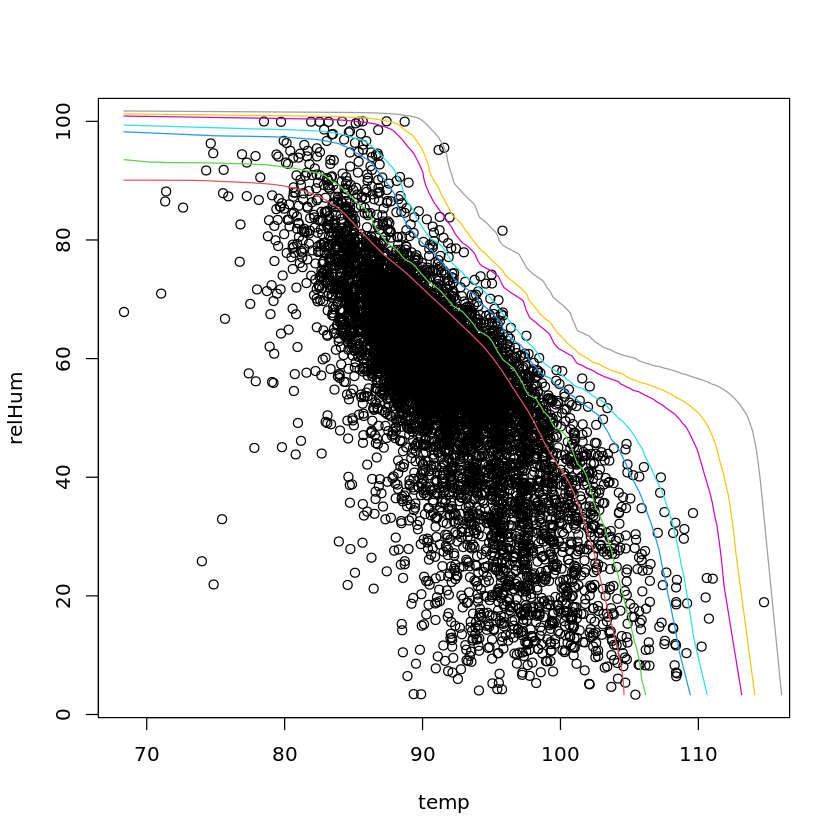

ERROR: Error in loadNamespace(x): there is no package called ‘evir’


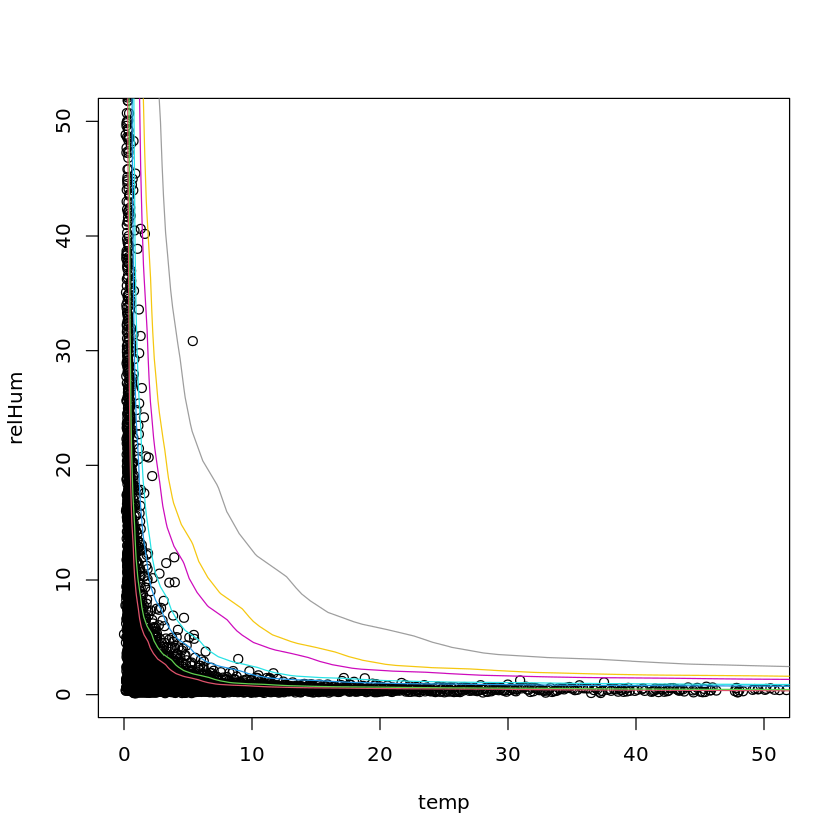

In [19]:
#karachi data
library(chron)
load("data/dans_data/karachiDatDaily.Rdata")
karachiOut <- xContours(dat = karachiDatDaily[, c("temp", "relHum")], asympIndep = T, 
			projContourLevels = c(.005, .001, .0005, .0001, .00005, .00001), beta = 200)
plotOrig(karachiOut)
plotFrec(karachiOut, xlim = c(0,50), ylim = c(0, 50))
etaDiag(karachiOut)
betaDiag(karachiOut, level = 3)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collaps

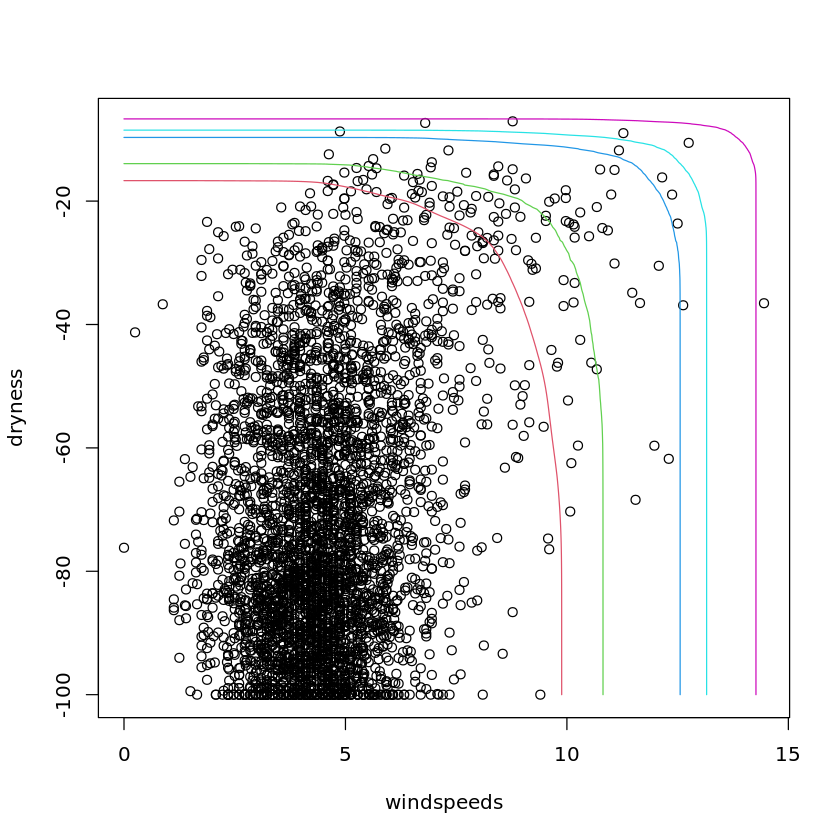

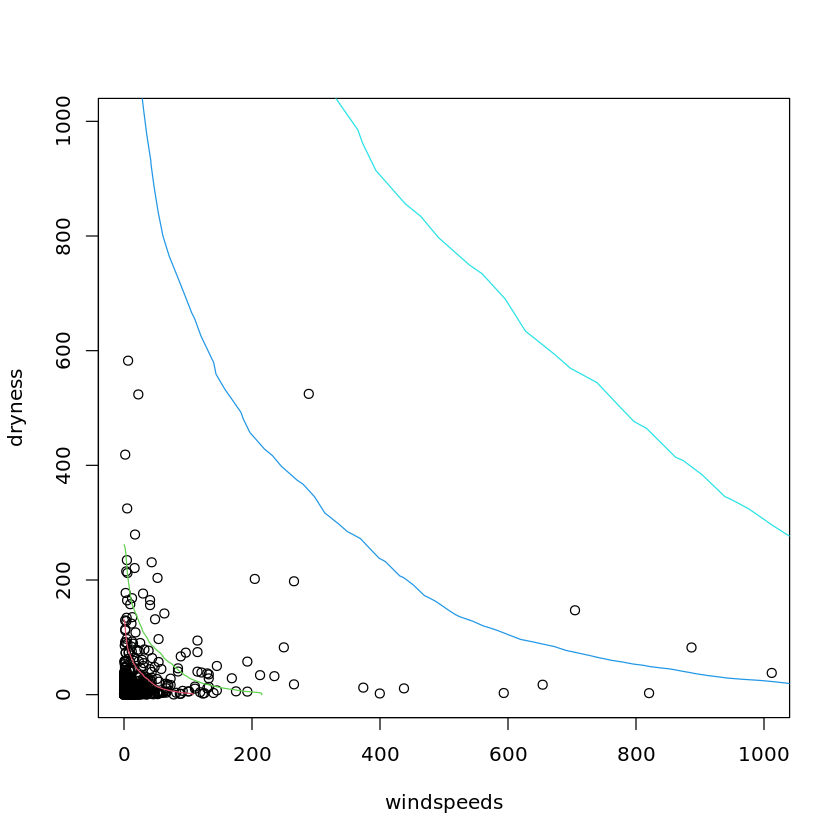

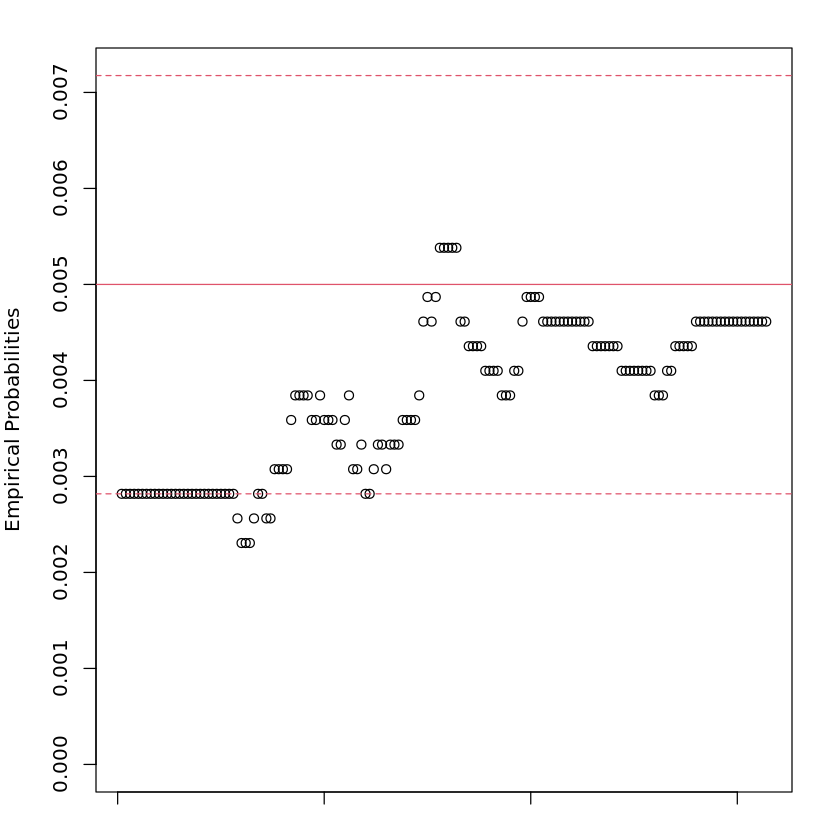

In [20]:
#santa ana data
load("data/dans_data/santaAnaBivariate.Rdata")
colnames(saDat)[5] <- "dryness"
santaAnaOut <- xContours(dat = saDat[, c("windspeeds", "dryness")], 
					projContourLevels = c(.005, .001, .0005, .0001))
plotOrig(santaAnaOut)
plotFrec(santaAnaOut, xlim = c(0, 1000), ylim = c(0, 1000))
betaDiag(santaAnaOut)  #still a useful plot even in asymptotic dependence case

## Paper Figures

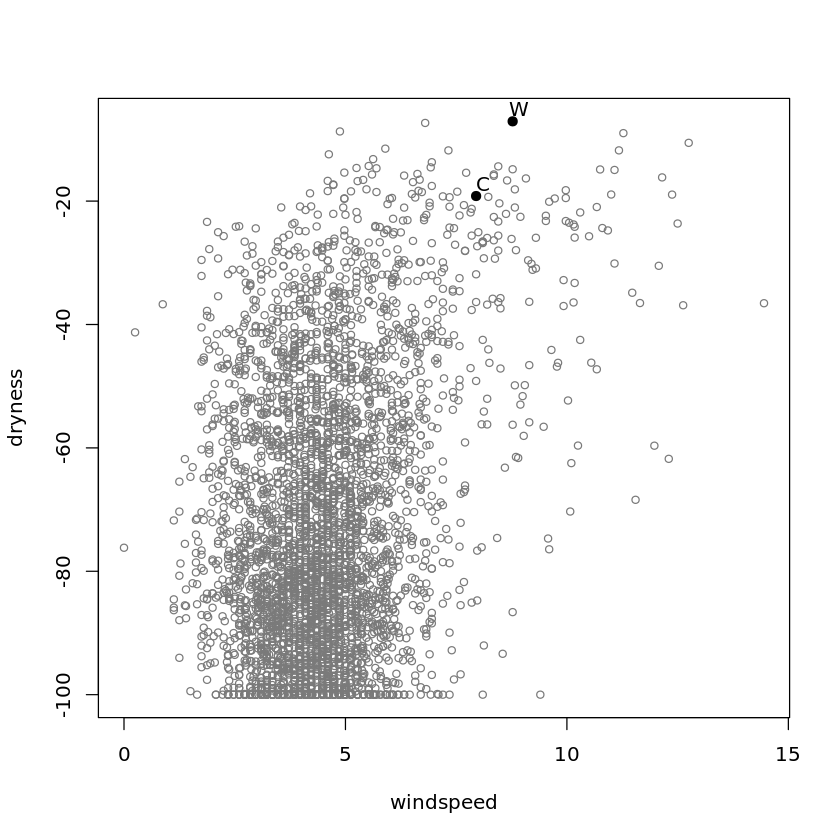

In [28]:
##################
#Figures for paper
##################
#santa ana motivation plot
#pdf("Dropbox/SharedContour/Fig/santaAnaMotivation.pdf", height = 5, width = 4.2)
plot(saDat[, c("windspeeds", "dryness")], xlab = "windspeed", ylab = "dryness", 
			pch = 1, cex = 0.8, col = "gray48")
cedarDay <- which(saDat[, "date"] == "10/25/2003")
witchDay <- which(saDat[, "date"] == "10/21/2007")
points(list( x = saDat[cedarDay, "windspeeds"], 
			 y = saDat[cedarDay, "dryness"]), 
			 col = 1, pch = 19)
text(x = saDat[cedarDay, "windspeeds"] + .15, 
			 y = saDat[cedarDay, "dryness"] + 2, 
			 labels = "C", col = 1)
points(list( x = saDat[witchDay, "windspeeds"], 
			 y = saDat[witchDay, "dryness"]), 
			 col = 1, pch = 19)
text(x = saDat[witchDay, "windspeeds"] + .15, 
			 y = saDat[witchDay, "dryness"] + 2,
			 labels = "W", col = 1)
#dev.off()

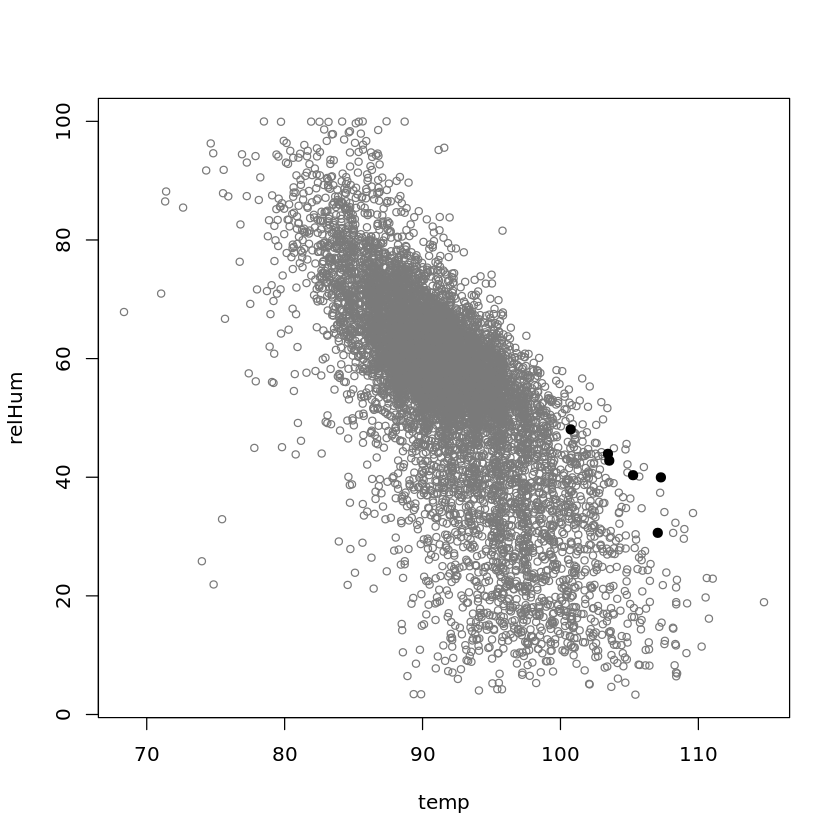

In [24]:
#karachi motivation plot
#pdf("Dropbox/SharedContour/Fig/karachiMotivation.pdf", height = 5, width = 4.2)
plot(karachiDatDaily[, c("temp", "relHum")], pch = 1, cex = 0.8, col = "gray48")
heatWaveDates <- karachiDatDaily[, "date"] < "06/24/15" & karachiDatDaily[, "date"] > "06/17/15"
points(karachiDatDaily[heatWaveDates, c("temp", "relHum")], pch = 19)
#dev.off()

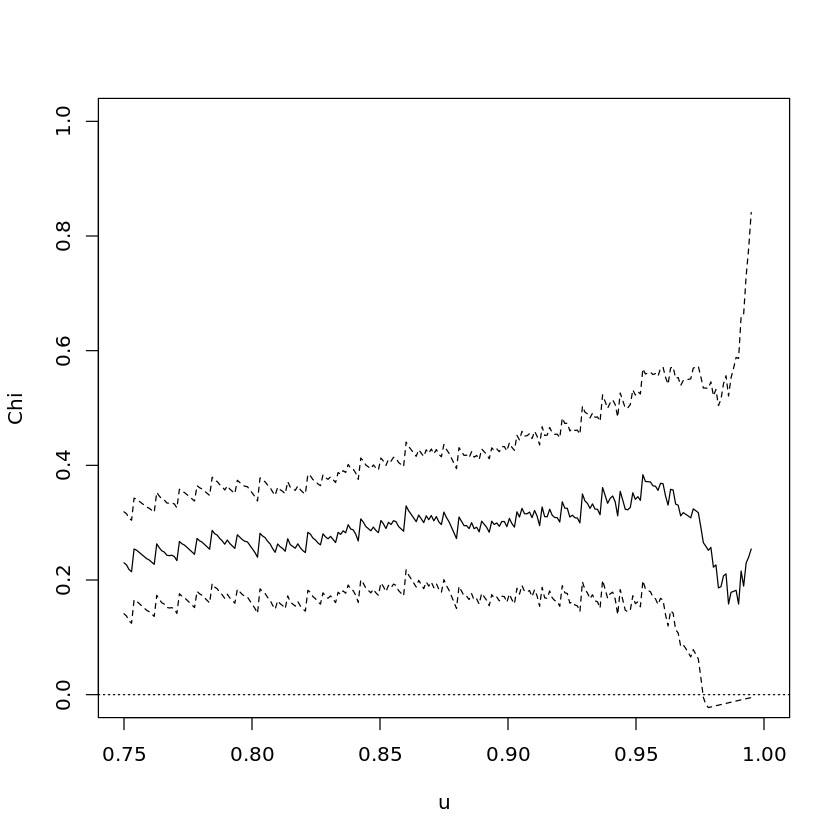

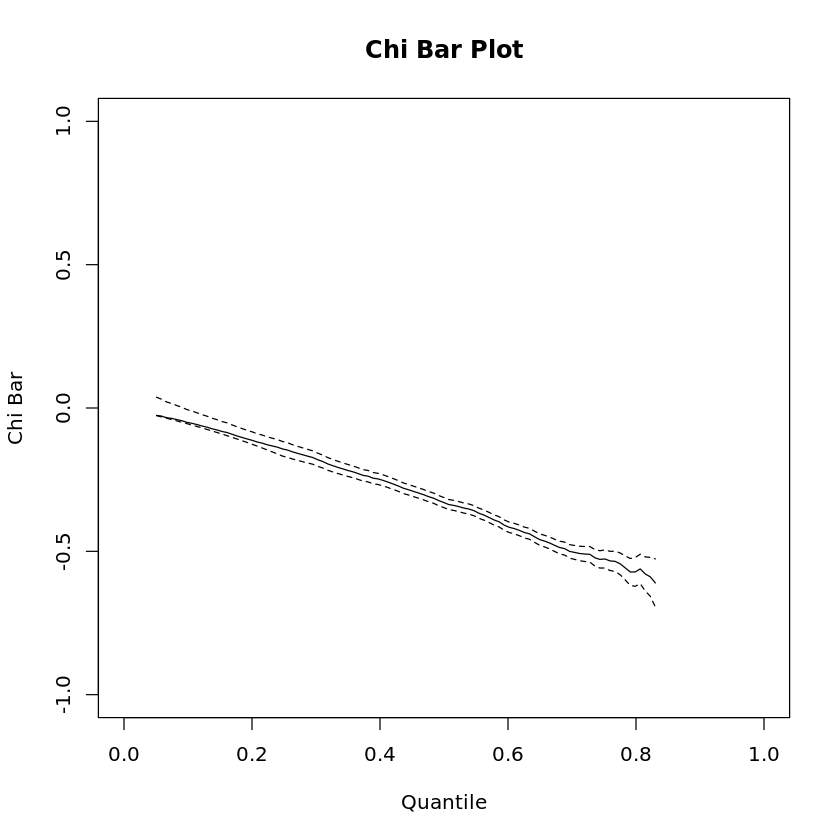

In [31]:
#chi plots

#pdf("Dropbox/SharedContour/Fig/santaAnaChi.pdf", height = 5, width = 4.2)
chiplot(saDat[, c("windspeeds", "dryness")], which = 1, nq = 250, xlim = c(.75, 1), 
				ylim1 = c(0,1), qlim = c(.75, .995), main1 = "", xlab = "u")
abline(h = 0, lty = 3)
#dev.off()

chiplot(karachiDatDaily[, c("temp", "relHum")], which = 2)

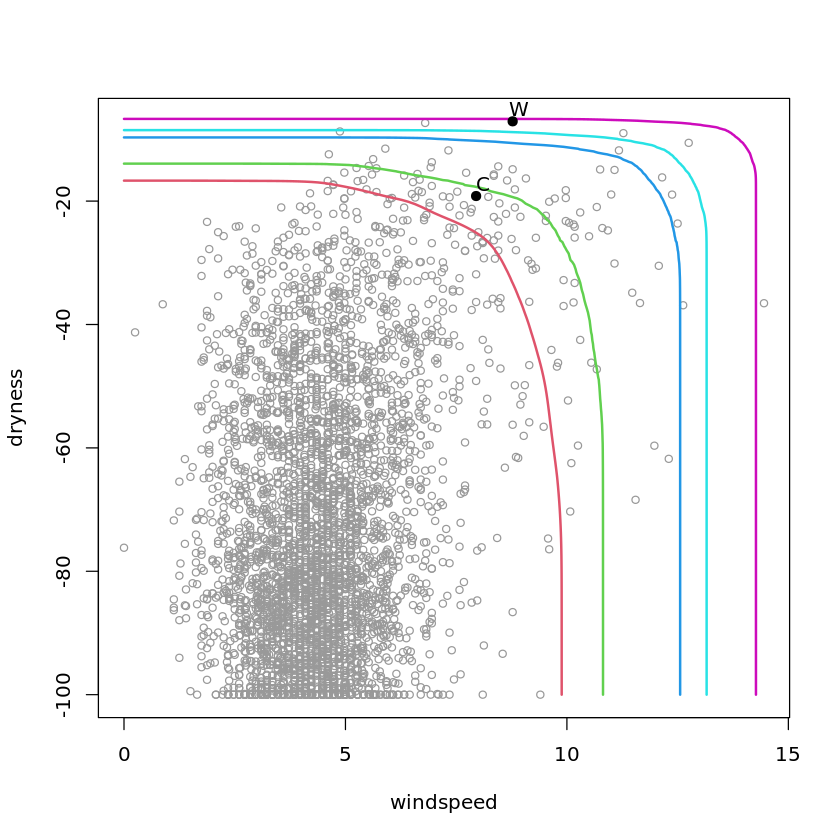

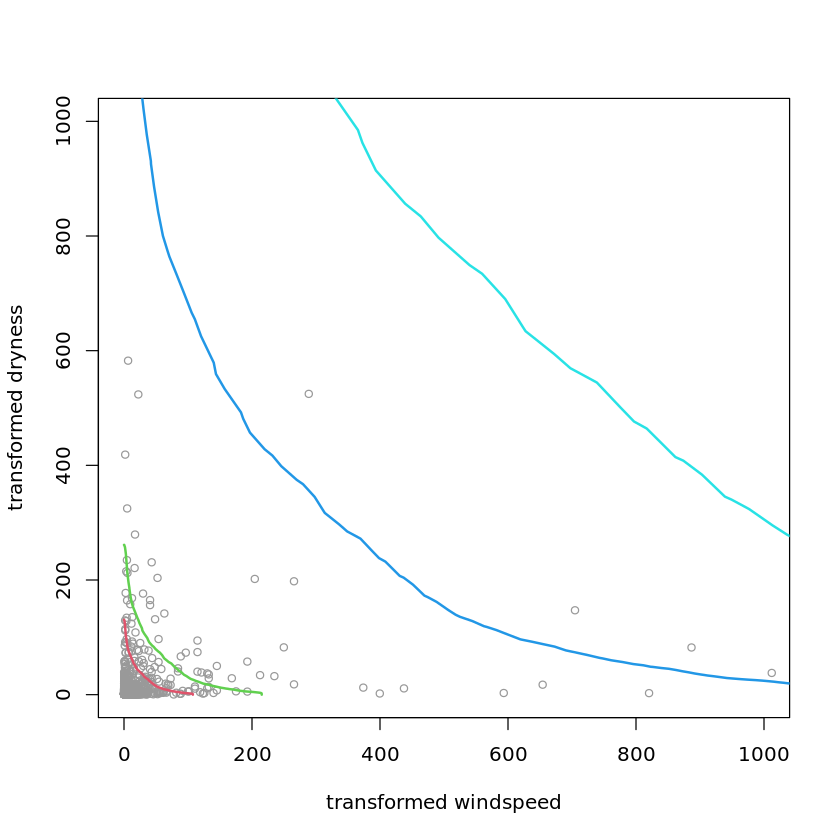

In [36]:
#santa Ana plots
#pdf("Dropbox/SharedContour/Fig/santaAnaOrigScale.pdf", height = 5, width = 4.2)
plotOrig(santaAnaOut, cex = 0.8, col = "gray60", xlab = "windspeed", ylab = "dryness", lwd = 2)
points(list( x = saDat[cedarDay, "windspeeds"], 
			 y = saDat[cedarDay, "dryness"]), 
			 col = 1, pch = 19)
text(x = saDat[cedarDay, "windspeeds"] + .15, 
			 y = saDat[cedarDay, "dryness"] + 2, 
			 labels = "C", col = 1)
points(list( x = saDat[witchDay, "windspeeds"], 
			 y = saDat[witchDay, "dryness"]), 
			 col = 1, pch = 19)
text(x = saDat[witchDay, "windspeeds"] + .15, 
			 y = saDat[witchDay, "dryness"] + 2,
			 labels = "W", col = 1)
#dev.off()
#pdf("Dropbox/SharedContour/Fig/santaAnaFrecScale.pdf", height = 5, width = 4.2)
plotFrec(santaAnaOut, xlim = c(0, 1000), ylim = c(0, 1000), xlab = "transformed windspeed", ylab = "transformed dryness", cex = 0.8, col = "gray60", lwd = 2)
#dev.off()

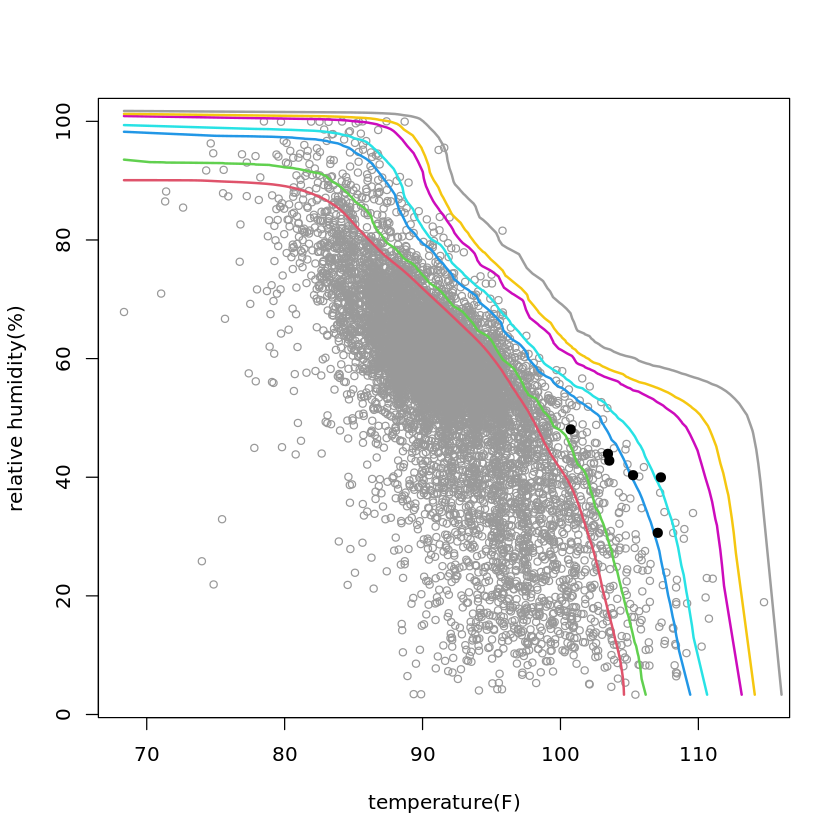

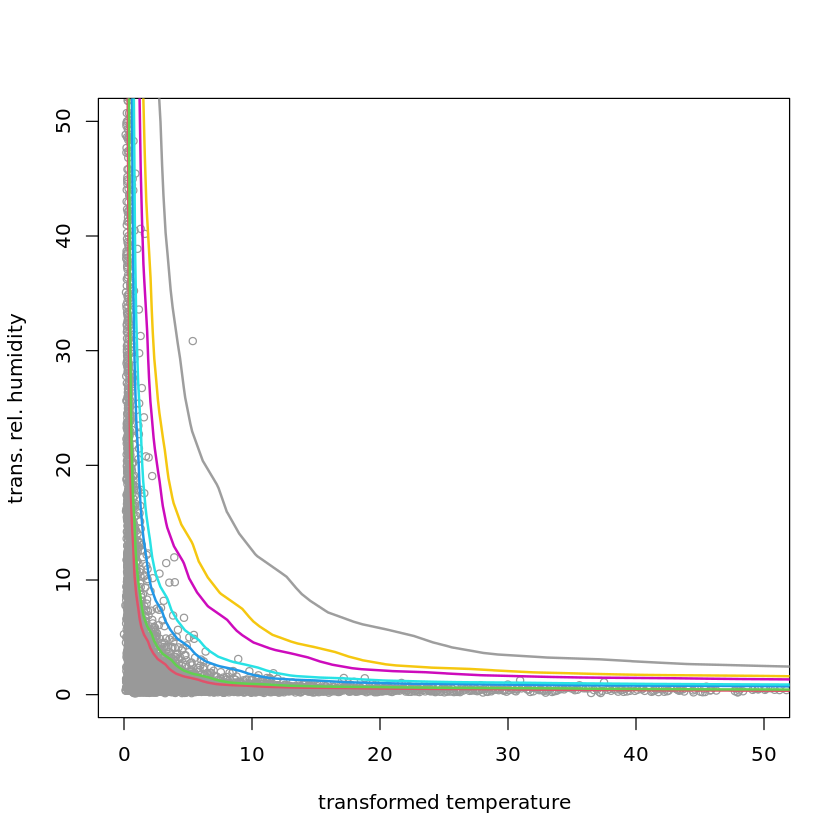

In [35]:
#karachiPlots
#pdf("Dropbox/SharedContour/Fig/karachiOrigScale.pdf", height = 5, width = 4.2)
plotOrig(karachiOut, cex = 0.8, col = "gray60", lwd = 2, xlab = "temperature(F)", ylab = "relative humidity(%)")
points(karachiDatDaily[heatWaveDates, c("temp", "relHum")], pch = 19)
#dev.off()
#pdf("Dropbox/SharedContour/Fig/karachiFrecScale.pdf", height = 5, width = 4.2)
plotFrec(karachiOut, cex = 0.8, col = "gray60", lwd = 2, xlab = "transformed temperature", 
	ylab = "trans. rel. humidity")
#dev.off()

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collaps

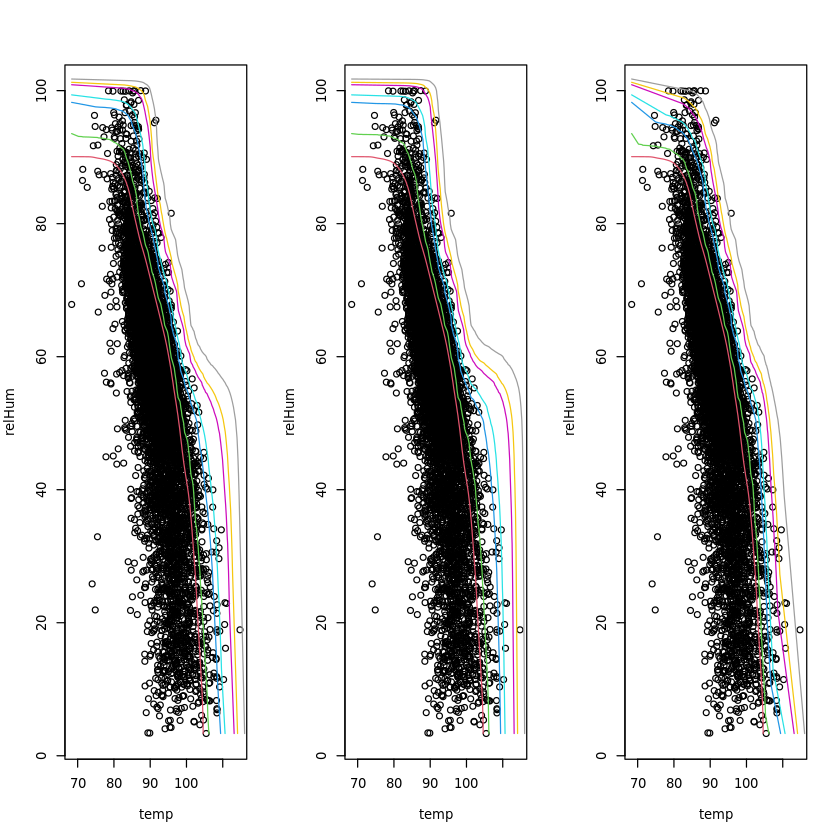

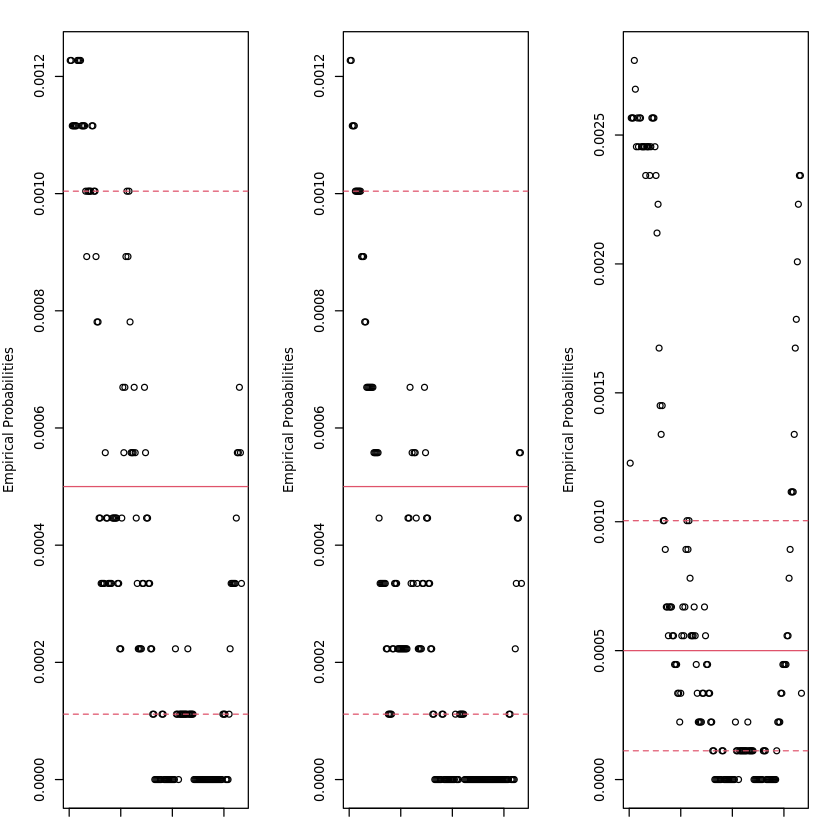

In [37]:
karachiOut50 <- xContours(dat = karachiDatDaily[, c("temp", "relHum")], asympIndep = T, 
			projContourLevels = c(.005, .001, .0005, .0001, .00005, .00001), beta = 50)
karachiOut1000 <- xContours(dat = karachiDatDaily[, c("temp", "relHum")], asympIndep = T, 
			projContourLevels = c(.005, .001, .0005, .0001, .00005, .00001), beta = 1000)
karachiOutDumb <- xContours(dat = karachiDatDaily[, c("temp", "relHum")], asympIndep = F, 
			projContourLevels = c(.005, .001, .0005, .0001, .00005, .00001))
par(mfrow = c(1,3))
plotOrig(karachiOut)
plotOrig(karachiOut50)
plotOrig(karachiOut1000)
#plotOrig(karachiOutDumb)
##
betaDiag(karachiOut, level = 3)
betaDiag(karachiOut50, level = 3)
betaDiag(karachiOut1000, level = 3)

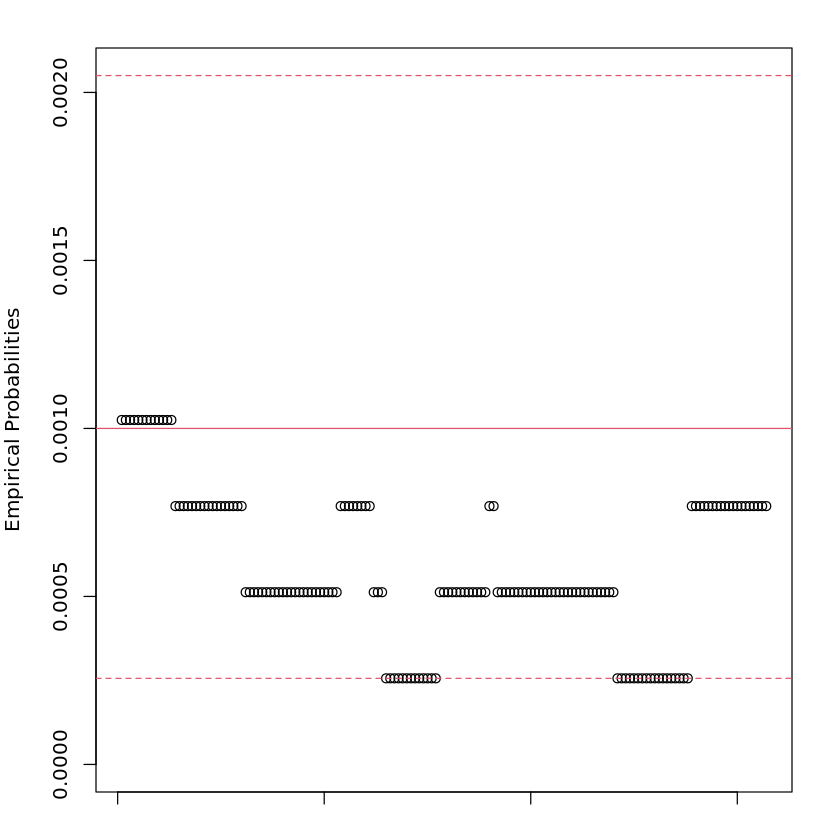

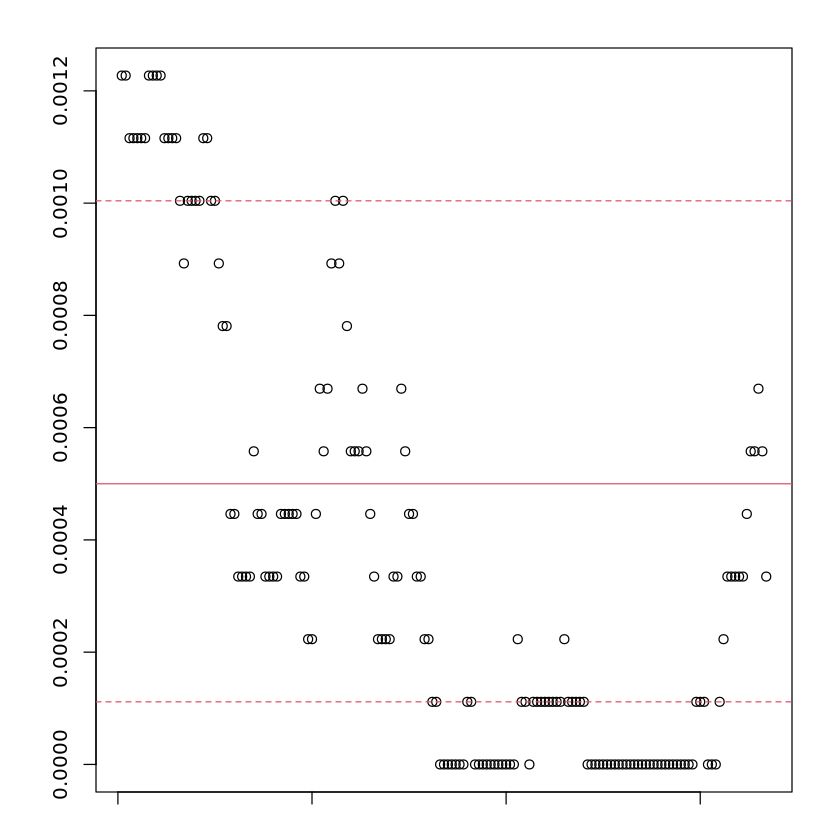

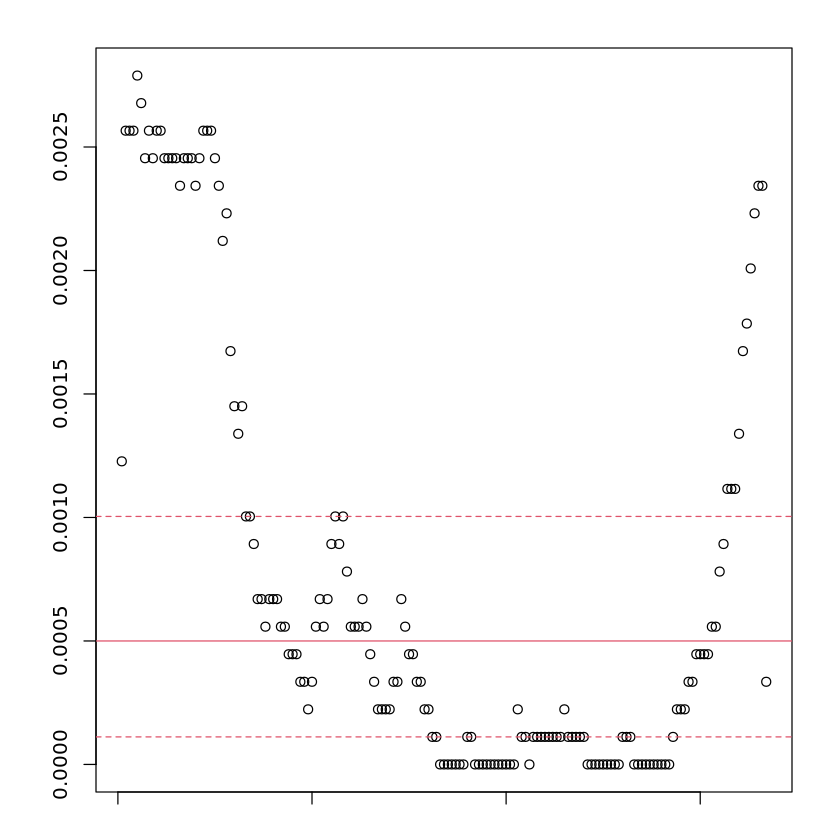

In [38]:
#pdf("Dropbox/SharedContour/Fig/santaAnaBeta.pdf", height = 4, width = 3.2)
betaDiag(santaAnaOut, level = 2)
#dev.off()
#pdf("Dropbox/SharedContour/Fig/karachiBeta.pdf", height = 4, width = 3.2)
betaDiag(karachiOut, level = 3, ylab = "")
#dev.off()
#pdf("Dropbox/SharedContour/Fig/karachi1000Beta.pdf", height = 4, width = 3.2)
betaDiag(karachiOut1000, level = 3, ylab = "")
#dev.off()

In [40]:
####################
# Bootstrap
####################
bootstrapBvpot <- function(outObj, blockSize, iter, bootContourLevel)
{
	bootContour <- list()
	
	for(k in 1:iter)
	{
		print(k)
	  	#obtain bootstrap sample
	  	n <- dim(outObj$dat)[1]
	  	sampLocs <- sample(n, size = ceiling(n/blockSize), replace = T)
	  	sampVals <- NULL
	  	for(i in 0:(blockSize-1))
	  	{
	  		sampVals <- rbind(sampVals, outObj$dat[sampLocs+0,])
	  	}
		sampVals <- sampVals[1:n,]
	
		bootContour[[k]] <- xContours(dat = sampVals, 
				mar1Prop = outObj$setup$mar1Prop, mar2Prop = outObj$setup$mar2Prop,
				mar1Width = outObj$setup$mar1Width, mar2Width = outObj$setup$mar2Width,
				baseContourLevel = outObj$setup$baseContourLevel, 
				projContourLevel = outObj$setup$projContourLevels,
				bw = outObj$setup$bw,
				gridSize = outObj$setup$gridSize,
				asympIndep = outObj$setup$asympIndep,
				etaProp = outObj$setup$etaProp,
				beta = outObj$setup$beta)	
	}
	
	return(bootContour)
}

karachiBoot <- bootstrapBvpot(karachiOut, 5, 200, 2)
#save(karachiBoot, file = "Dropbox/SharedContour/Data/karachiBoot.RData")
			
#pdf("Dropbox/SharedContour/Fig/karachiBootstrap.pdf", height = 5, width = 4.2)
plot(karachiDatDaily[, c("temp", "relHum")], pch = 1, cex = 0.8, col = "gray68")
points(karachiBoot[[1]]$data)
for(k in seq(1, length(karachiBoot)))
{
	lines(karachiBoot[[k]]$projContours[[2]], col = "gray48")
}
lines(karachiOut$projContours[[2]], col = 4, lwd = 3)
#dev.off()

#santaAnaBoot <- bootstrapBvpot(santaAnaOut, 3, 200, 2)
#save(santaAnaBoot, file = "Dropbox/SharedContour/Data/santaAnaBoot.RData")
pdf("Dropbox/SharedContour/Fig/santaAnaBootstrap.pdf", height = 5, width = 4.2)
plot(saDat[, c("windspeeds", "dryness")], pch = 1, cex = 0.8, col = "gray68")
points(santaAnaBoot[[1]]$data)
for(k in seq(1, length(santaAnaBoot)))
{
	lines(santaAnaBoot[[k]]$projContours[[2]], col = "gray48")
}
lines(santaAnaOut$projContours[[2]], col = 4, lwd = 3)
dev.off()

[1] 1


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
